# __Préparation du `tf.data.Dataset`__

Ce notebook met en place le pipeline de données utilisé pour entraîner les modèles de segmentation :

1. Lecture des fichiers `TFRecords`
2. Décodage des couples `image / masque`
3. Normalisation des images
4. Préparation en `batch`, `shuffle` et `prefetch`

__Objectif__ : créer un `tf.data.Dataset` propre, reproductible et efficace.



In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
import albumentations as A
import mlflow
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path


## 1. __Lecture des fichiers `TFRecords`__

In [2]:
# Définir les chemins

# Dossier contenant les TFRecords (ajuste si besoin)
tfrecord_dir = Path("../data/processed/tfrecords")

# Chemins vers les fichiers
tfrecord_paths = {
    "train": tfrecord_dir / "train.tfrecord",
    "val": tfrecord_dir / "val.tfrecord",
    "test": tfrecord_dir / "test.tfrecord"
}

# Vérification existence
for split, path in tfrecord_paths.items():
    assert path.exists(), f"Fichier {split} manquant : {path}"
    print(f"Fichier {split} trouvé : {path}")


Fichier train trouvé : ../data/processed/tfrecords/train.tfrecord
Fichier val trouvé : ../data/processed/tfrecords/val.tfrecord
Fichier test trouvé : ../data/processed/tfrecords/test.tfrecord


In [3]:
# Chargement brut avec tf.data.TFRecordDataset

# Chargement brut (non encore parsé)
raw_datasets = {
    split: tf.data.TFRecordDataset(str(path))
    for split, path in tfrecord_paths.items()
}

# Affichage exemple (objet brut, encore vide)
raw_datasets["train"]


<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [4]:
n_samples = sum(1 for _ in raw_datasets["train"])
print(f"Nombre d'exemples dans raw train TFRecord : {n_samples}")


Nombre d'exemples dans raw train TFRecord : 2975


2025-10-06 10:45:05.843880: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-10-06 10:45:05.994533: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Les fichiers `.tfrecord` ont été générés à partir des couples `(image, masque)` traités précédemment.  
Ils sont ici lus comme des objets `TFRecordDataset` bruts, que nous allons ensuite __parser__ et __prétraiter__ dans les étapes suivantes.


## 2. __Décodage des couples `image / masque`__

Cette étape est __cruciale__ car elle va :
- décompresser les données binaires contenues dans chaque `TFRecord`
- extraire les images et les masques
- __vérifier qu'ils sont bien appariés__ (image[i] ↔ masque[i])  

Cela nous permettra aussi de visualiser un exemple.  

Nous allons d'abord créer une fonction de parsing d'un exemple.  
Chaque élément du `TFRecord` contient deux _features_ encodées :
`"image"` et `"mask"` sous forme de chaînes de bytes (`tf.string`).

In [5]:
# Fonction de parsing d'un exemple

def parse_example(example_proto):
    """
    Décode un exemple TFRecord en couple (image, masque).
    """
    # Description du format
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
    }

    # Parsing
    example = tf.io.parse_single_example(example_proto, feature_description)

    # Décodage
    image = tf.io.decode_png(example["image"], channels=3)  # (H, W, 3)
    mask = tf.io.decode_png(example["mask"], channels=1)    # (H, W, 1)

    return image, mask


In [6]:
# Tester le décodage sur quelques exemples

# Appliquer le parsing sur les datasets bruts
parsed_train_ds = raw_datasets["train"].map(parse_example)
parsed_val_ds   = raw_datasets["val"].map(parse_example)
parsed_test_ds  = raw_datasets["test"].map(parse_example)

# Afficher un exemple
for image, mask in parsed_train_ds.take(1):
    print("Image :", image.shape, image.dtype)
    print("Masque :", mask.shape, mask.dtype)

for image, mask in parsed_val_ds.take(1):
    print("VAL Image :", image.shape, image.dtype)
    print("VAL Masque :", mask.shape, mask.dtype)

for image, mask in parsed_test_ds.take(1):
    print("TEST Image :", image.shape, image.dtype)
    print("TEST Masque :", mask.shape, mask.dtype)



Image : (512, 256, 3) <dtype: 'uint8'>
Masque : (512, 256, 1) <dtype: 'uint8'>
VAL Image : (512, 256, 3) <dtype: 'uint8'>
VAL Masque : (512, 256, 1) <dtype: 'uint8'>
TEST Image : (512, 256, 3) <dtype: 'uint8'>
TEST Masque : (512, 256, 1) <dtype: 'uint8'>


2025-10-06 10:45:08.719804: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-06 10:45:08.744765: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


__Création d'une palette personnalisée__

| Classe         | ID | Objet                      | Couleur (RGB)  | Couleur (nom) |
| -------------- | -- | -------------------------- | -------------- | ------------- |
| `0`            | 0  | Route                      | (128, 64, 128) | Mauve foncé   |
| `1`            | 1  | Trottoir                   | (244, 35, 232) | Rose clair    |
| `2`            | 2  | Bâtiments / murs           | (70, 70, 70)   | Gris foncé    |
| `3`            | 3  | Panneaux / feux            | (220, 220, 0)  | Jaune         |
| `4`            | 4  | Végétation + terrain       | (107, 142, 35) | Vert olive    |
| `5`            | 5  | Ciel                       | (70, 130, 180) | Bleu ciel     |
| `6`            | 6  | Piétons / riders           | (220, 20, 60)  | Rouge vif     |
| `7`            | 7  | Véhicules (car, bus, etc.) | (0, 0, 142)    | Bleu foncé    |
| `255` (ignore) | -- | Classe ignorée             | (0, 0, 0)      | Noir          |


In [7]:
# Palette RGB pour les 8 classes + classe ignorée (255)
PALETTE_8CLASS = np.array([
    [128, 64, 128],   # 0: route
    [244, 35, 232],   # 1: trottoir
    [70, 70, 70],     # 2: bâtiments/murs
    [220, 220, 0],    # 3: panneaux/feux
    [107, 142, 35],   # 4: végétation/terrain
    [70, 130, 180],   # 5: ciel
    [220, 20, 60],    # 6: piétons/riders
    [0, 0, 142],      # 7: véhicules
    [0, 0, 0]         # 255: ignore (affiché en noir)
], dtype=np.uint8)


In [8]:
def decode_segmentation_mask(mask, palette=PALETTE_8CLASS):
    """
    Convertit une image de masques (valeurs entre 0 et 7 ou 255) en image RGB.
    """
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

    for class_id in range(len(palette)):
        rgb_mask[mask == class_id] = palette[class_id]

    return rgb_mask


In [9]:
def show_image_mask_batch_colored(dataset, n=3):
    images, masks = [], []

    for img, mask in dataset.take(n):
        images.append(img.numpy())
        masks.append(decode_segmentation_mask(mask.numpy()[..., 0]))

    plt.figure(figsize=(4 * n, 6))
    
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.title(f"Image {i+1}")
        plt.axis("off")
        
    for i in range(n):
        plt.subplot(2, n, n + i + 1)
        plt.imshow(masks[i])
        plt.title(f"Masque {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()



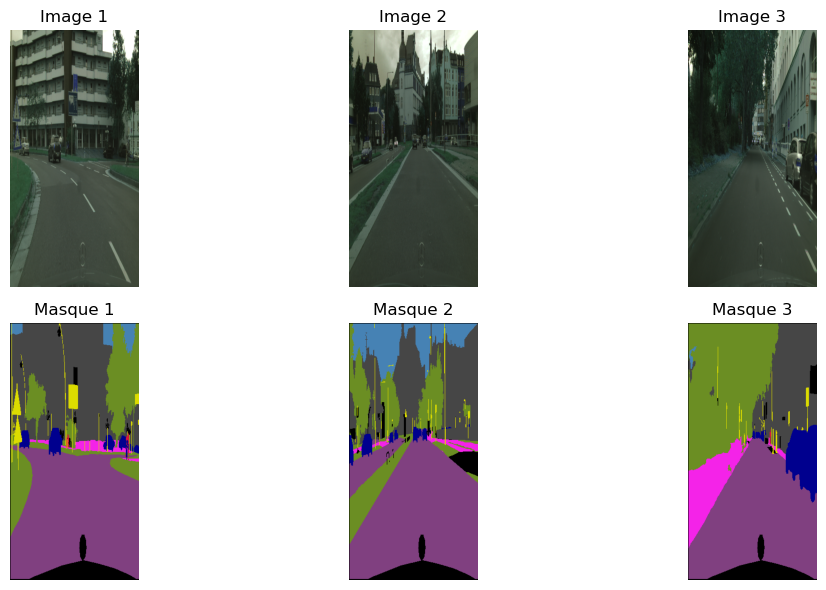

In [10]:
show_image_mask_batch_colored(parsed_train_ds, n=3)


## 3. __Normalisation des images__ 

L'objectif ici consiste à mettre les images dans une échelle de valeurs [0, 1] pour faciliter l’entraînement des modèles, tout __en laissant les masques inchangés__ (puisqu’ils contiennent des entiers de classes).  

- La normalisation est légère (division par 255), donc peu coûteuse et compatible avec tous les modèles CNN (`U-Net`, `DeepLab`, etc.).
- Elle est indispensable pour permettre au modèle de converger rapidement sans gradients explosifs.
- Nous pourrions plus tard ajouter une standardisation `mean/std` pour s'aligner avec un backbone pré-entraîné.

In [11]:
# Fonction de normalisation propre

def normalize_image_mask(image, mask):
    """
    Normalise l’image entre 0 et 1. Laisse le masque tel quel.
    """
    image = tf.cast(image, tf.float32) / 255.0  # Normalisation
    return image, mask


In [12]:
# Application au dataset

normalized_train_ds = parsed_train_ds.map(normalize_image_mask)
normalized_val_ds = parsed_val_ds.map(normalize_image_mask)
normalized_test_ds = parsed_test_ds.map(normalize_image_mask)


Image min/max : 0.059 / 1.000


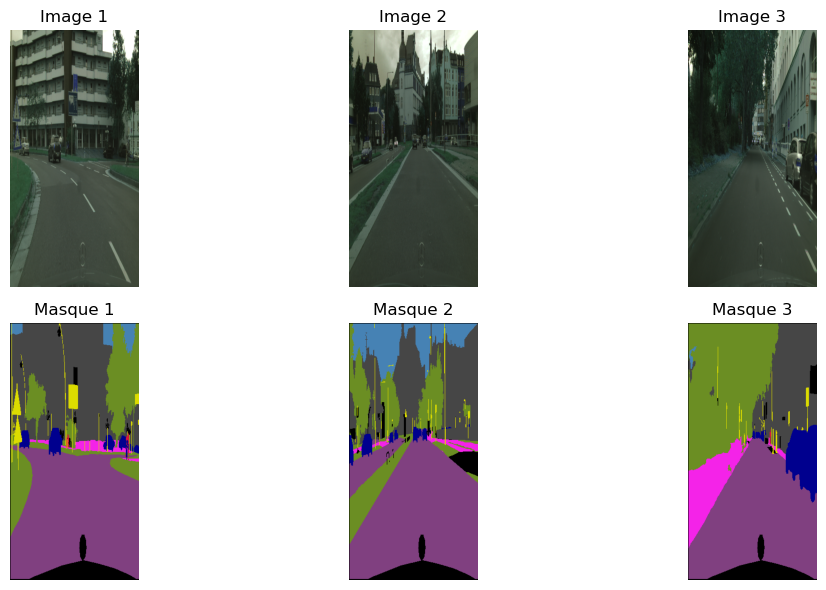

In [14]:
for img, mask in normalized_train_ds.take(1):
    print(f"Image min/max : {tf.reduce_min(img).numpy():.3f} / {tf.reduce_max(img).numpy():.3f}")
    show_image_mask_batch_colored(normalized_train_ds, n=3)


## 4. __Préparation en `batch`, `shuffle`, `prefetch`__

1. `Batching` : 
- On regroupe nos exemples en lots (batches). Ex : plutôt que de traiter 1 image à la fois → on traite 8, 16, 32 d’un coup. 
- Plus rapide : meilleure vectorisation sur CPU (ou GPU plus tard)
- Indispensable pour `model.fit()`
- Permet une estimation plus stable de la loss et des gradients.

2. `Shuffling` :
- On mélange les exemples (uniquement sur le jeu d'entraînement) à chaque époque.
- Empêche le modèle de "voir" les mêmes séquences d'images à chaque époque
- Évite l'__overfitting__ sur des motifs de position.
- __Uniquement sur le split train__ ! Pas de shuffle sur val/test.

3. `Prefetching` :
- Pendant que le modèle entraîne le batch _n_, il prépare déjà le batch _n+1_ en tâche de fond.
- Optimise le débit et évite les temps morts dus au chargement disque.


In [15]:
BATCH_SIZE = 8

train_ds_final = parsed_train_ds.shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds_final   = parsed_val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds_final  = parsed_test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [17]:
for images, masks in train_ds_final.take(1):
    print("Images :", images.shape, images.dtype)
    print("Masques :", masks.shape, masks.dtype)

Images : (8, 512, 256, 3) <dtype: 'uint8'>
Masques : (8, 512, 256, 1) <dtype: 'uint8'>
